In [1]:
from modulos import ann, eda, ml_func
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

2025-08-18 11:01:16.731214: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# ML - Bacia do Rio Negro

### Estações

Fonte: https://www.snirh.gov.br/hidroweb/serieshistoricas

Bacia: 1 - RIO AMAZONAS\
SubBacia: 14 - RIO SOLIMÕES,NEGRO,BRANCO,...\

1. 14280001\
Rio: Rio Vaupés/Uaupés\
Nome: Taraquá\
Estado: Amazonas\
Município: São Gabriel da Cachoeira\
Responsável: ANA\
Operadora: SGB-PCRM\
Latitude: 0.1303°\
Longitude: -68.5386°

2. 14300000\
Rio: Rio Tiquié\
Nome: Pari Cachoeira\
Estado: Amazonas\
Município: São Gabriel da Cachoeira\
Responsável: ANA\
Operadora: SGB-PCRM\
Latitude: 0.2494°\
Longitude: -69.785°

3. 14350000\
Rio: Rio Curicuriari\
Nome: Jusante da Cachoeira do Caju\
Estado: Amazonas\
Município: São Gabriel da Cachoeira\
Responsável: ANA\
Operadora: SGB-PCRM\
Latitude: -0.2461°\
Longitude: -67.0092°

4. 14550000\
Rio: Rio Cotingo\
Nome: Maloca do Contão\
Estado: Roraima\
Município: Pacaraima\
Responsável: ANA\
Operadora: SGB-PCRM\
Latitude: 4.1675°\
Longitude: -60.5289°

5. 14790000\
Rio: Rio Branco\
Nome: Santa Maria do Boiaçu\
Estado: Roraima\
Município: Rorainopólis\
Responsável: ANA\
Operadora: SGB-PCRM\
Latitude: -0.5053°\
Longitude: -61.7864°

6. 14990000\
Nome: Manaus\
Estado: Amazonas\
Município: Manaus\
Responsável: ANA\
Operadora: SGB-CPRM\
Latitude: -3.1383°\
Longitude: -60.0272°

In [2]:
arquivos = [
    'dados_diarios_estacao_14280001.csv',
    'dados_diarios_estacao_14300000.csv',
    'dados_diarios_estacao_14350000.csv',
    'dados_diarios_estacao_14550000.csv',
    'dados_diarios_estacao_14790000.csv',
    'dados_diarios_estacao_14990000.csv'
]

dados = eda.data_processing('Cotas extraidas', '1985-01-01', '2024-12-31', arquivos)
dados

,14280001,14300000,14350000,14550000,14790000,14990000
Data,,,,,,
1985-01-01,1319.0,842.0,1471.0,204.0,509.0,2169.0
1985-01-02,1317.0,822.0,1476.0,186.0,503.0,2178.0
1985-01-03,1311.0,798.0,1487.0,178.0,498.0,2186.0
1985-01-04,1301.0,751.0,1509.0,178.0,504.0,2194.0
1985-01-05,1286.0,709.0,1529.0,177.0,510.0,2201.0
...,...,...,...,...,...,...
2024-12-27,1150.0,594.0,1495.0,150.0,369.0,1751.0
2024-12-28,1157.0,555.0,1509.0,141.0,372.0,1769.0
2024-12-29,1178.0,545.0,1523.0,144.0,371.0,1785.0


### Gráficos

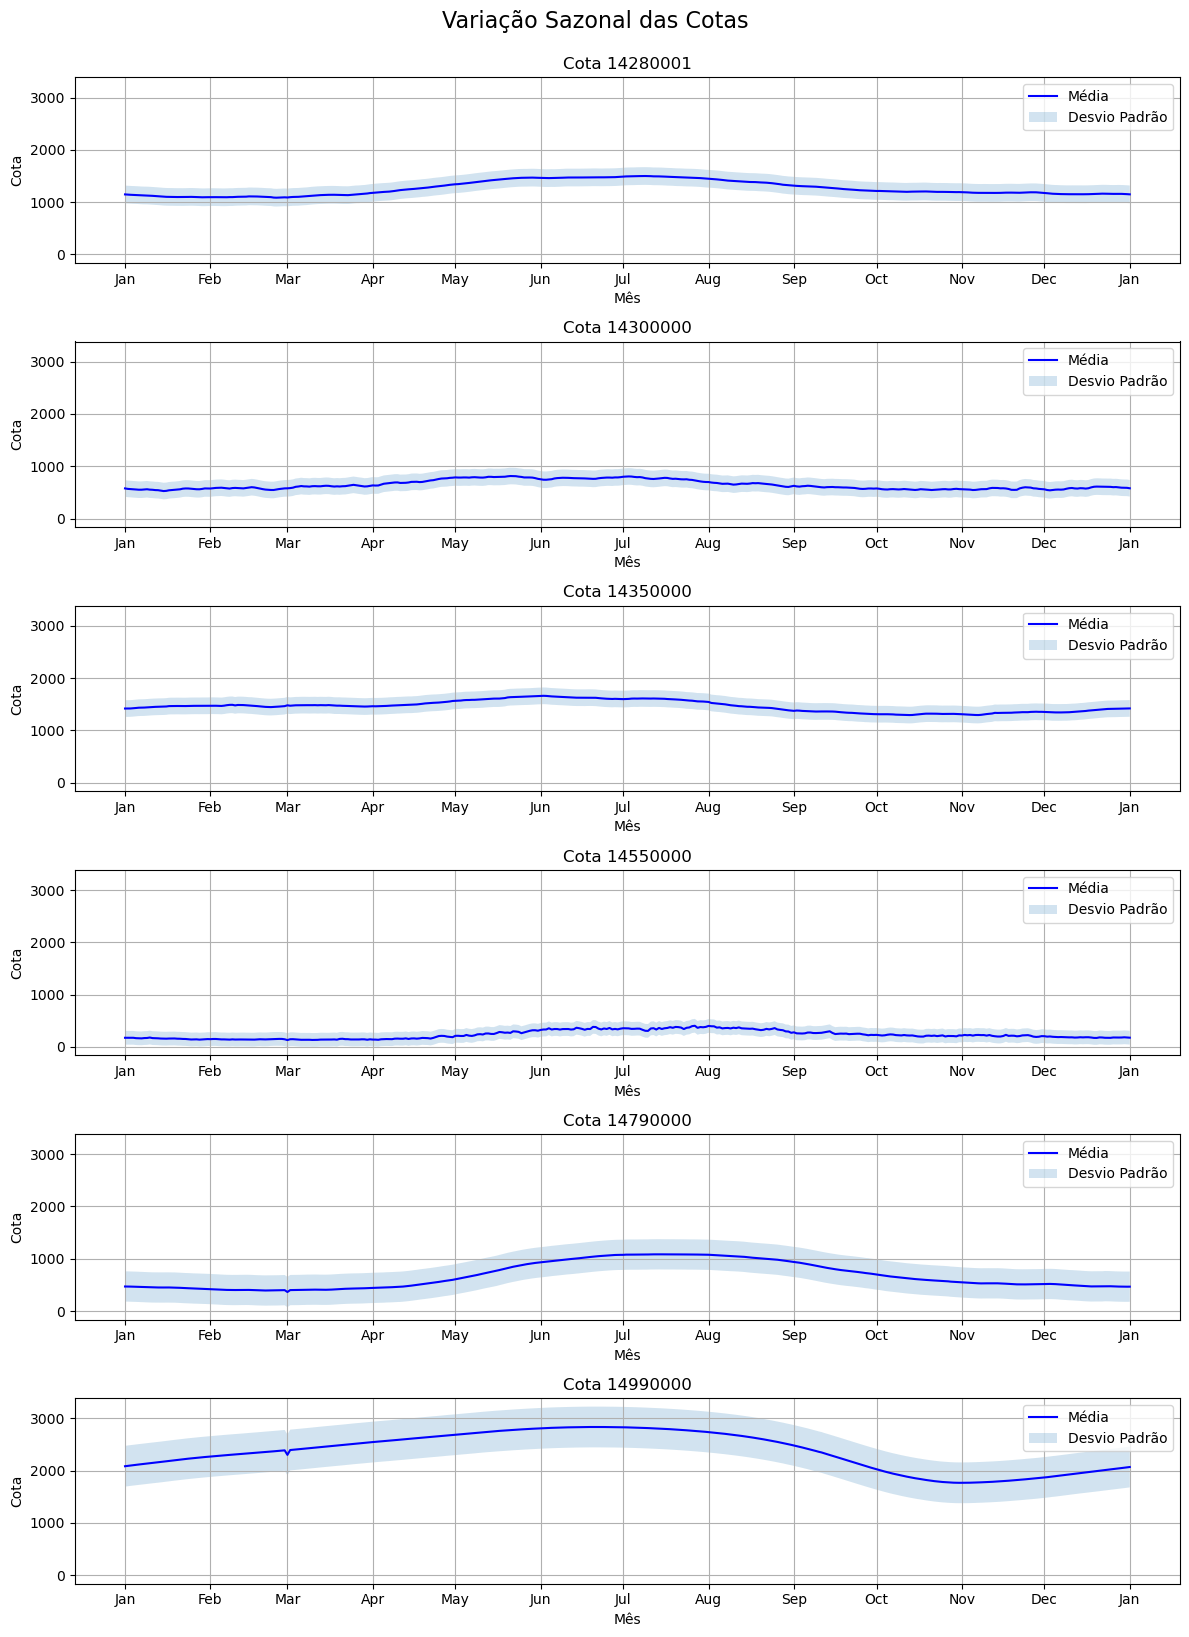

In [3]:
eda.seasonal_plot(dados, (12, 16))

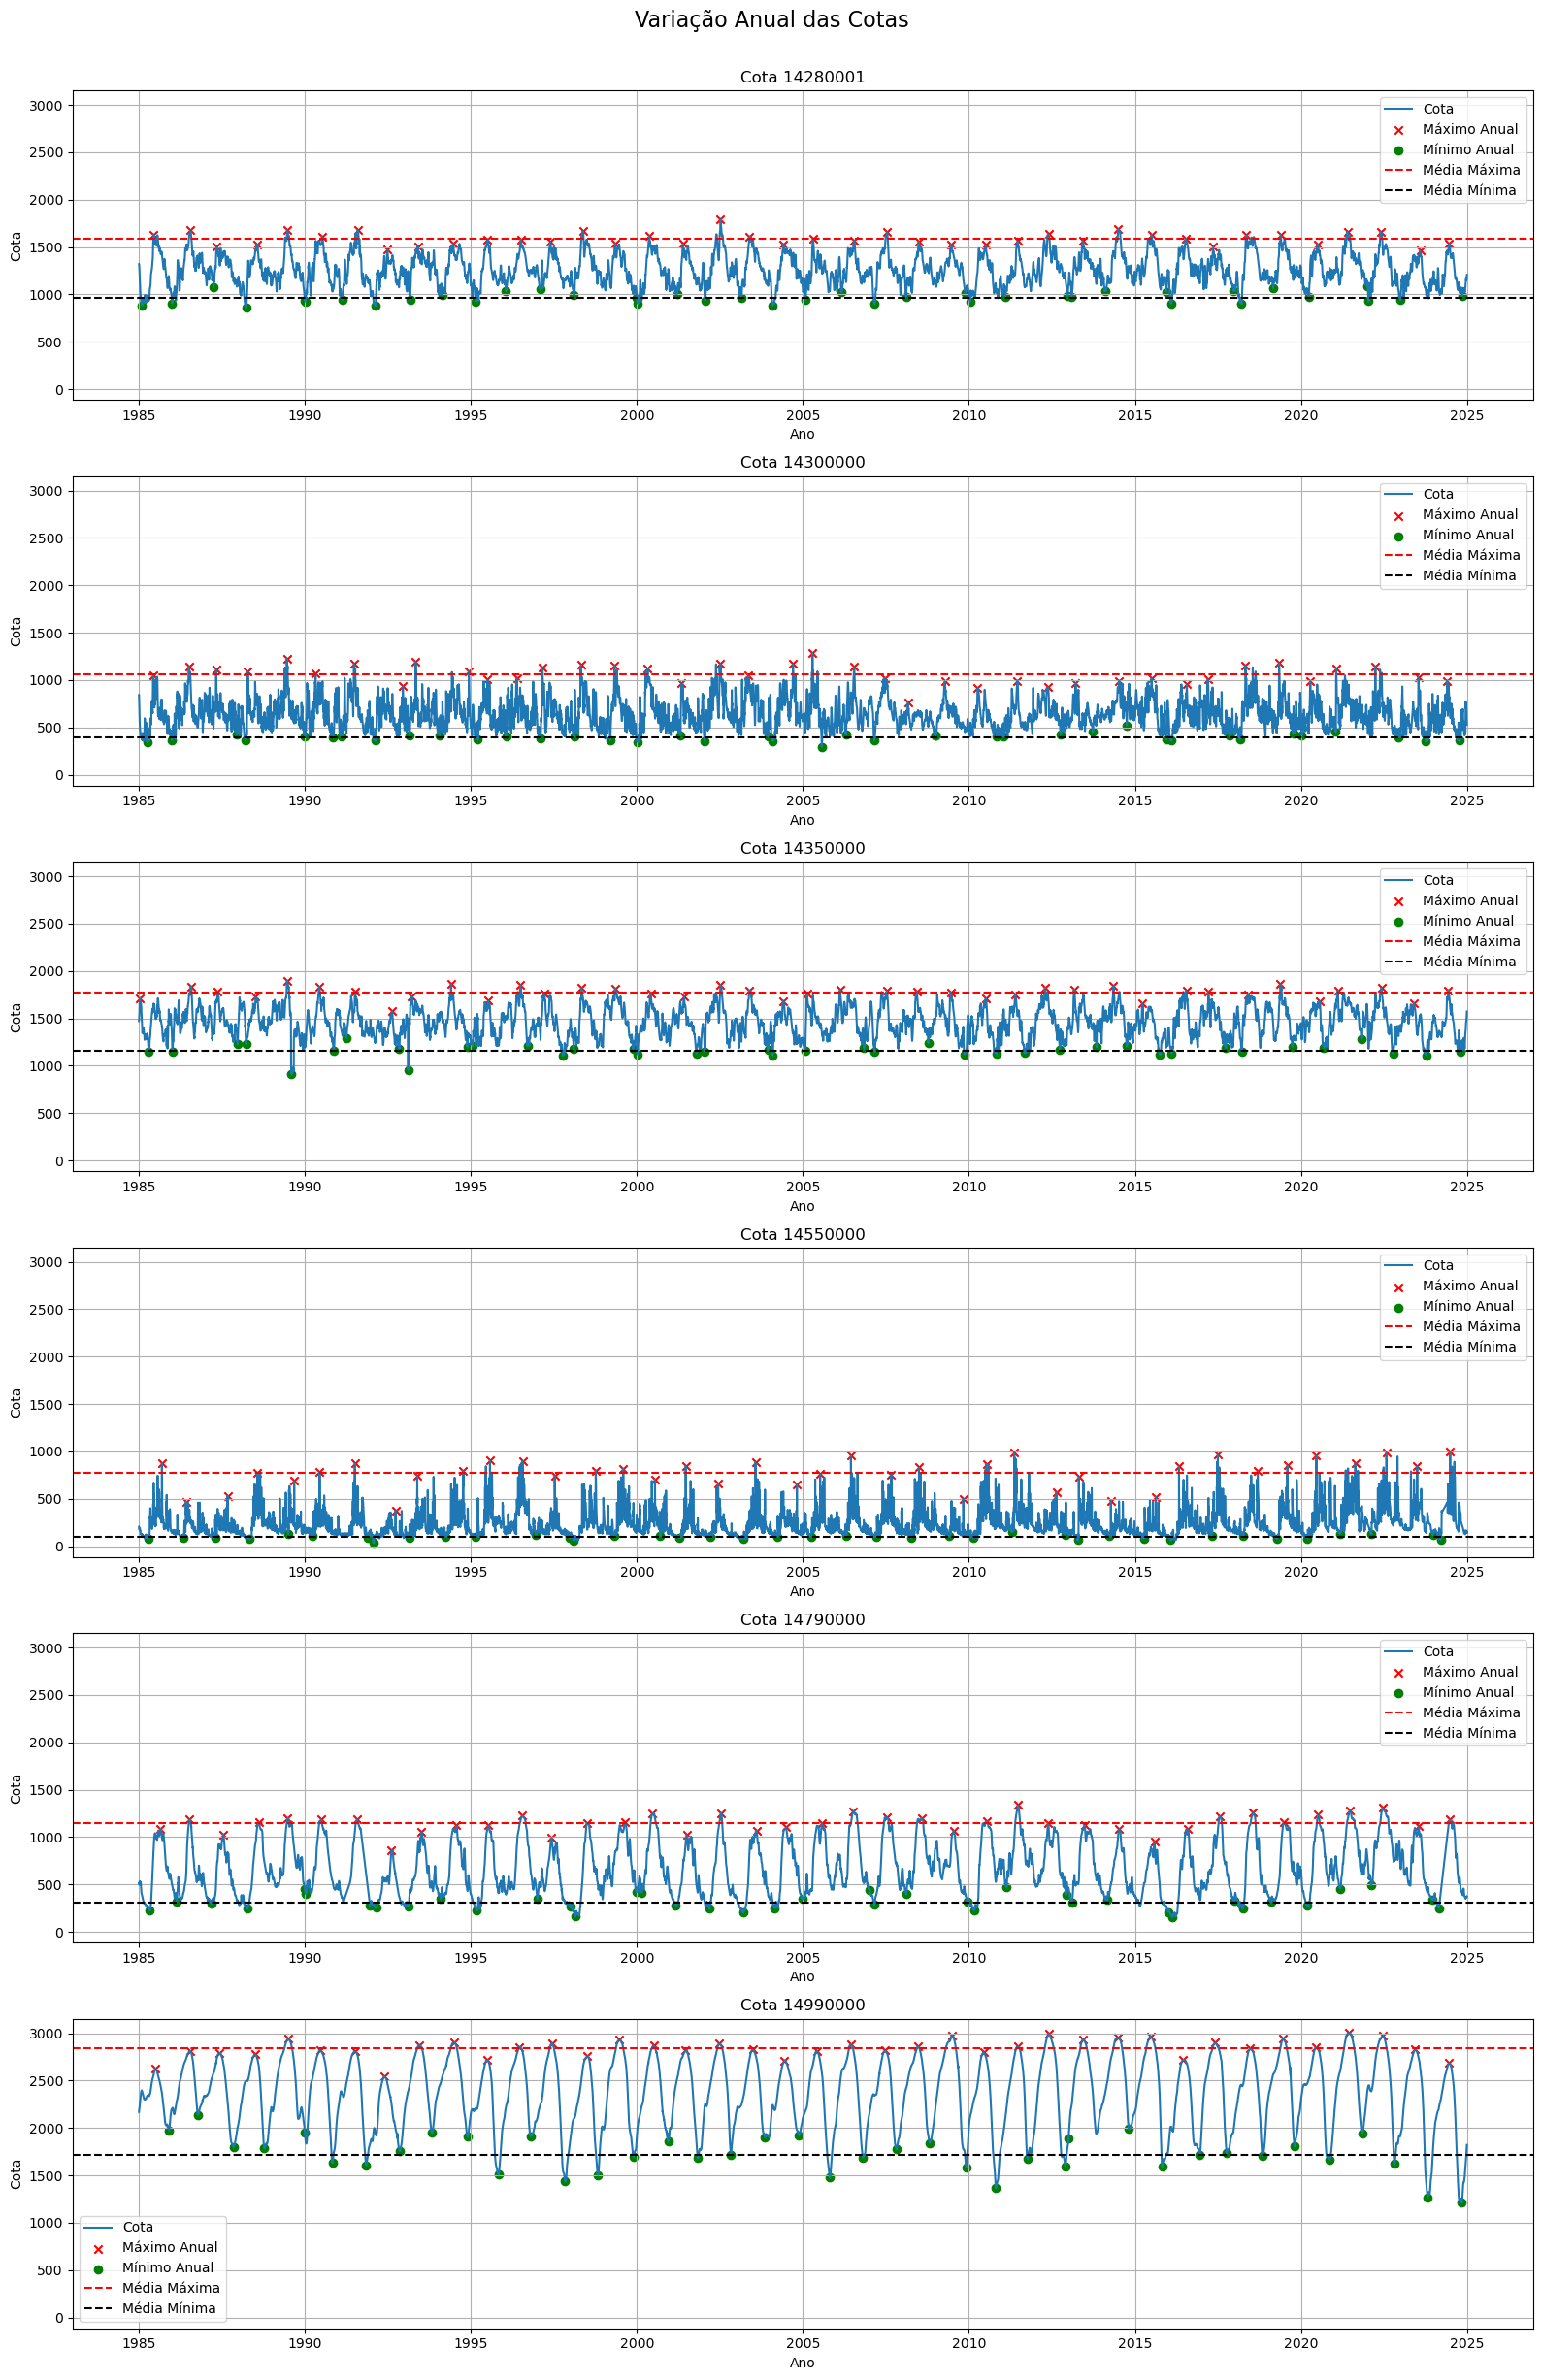

In [4]:
eda.annual_plot(dados, (16, 24))

### Separação dos conjuntos

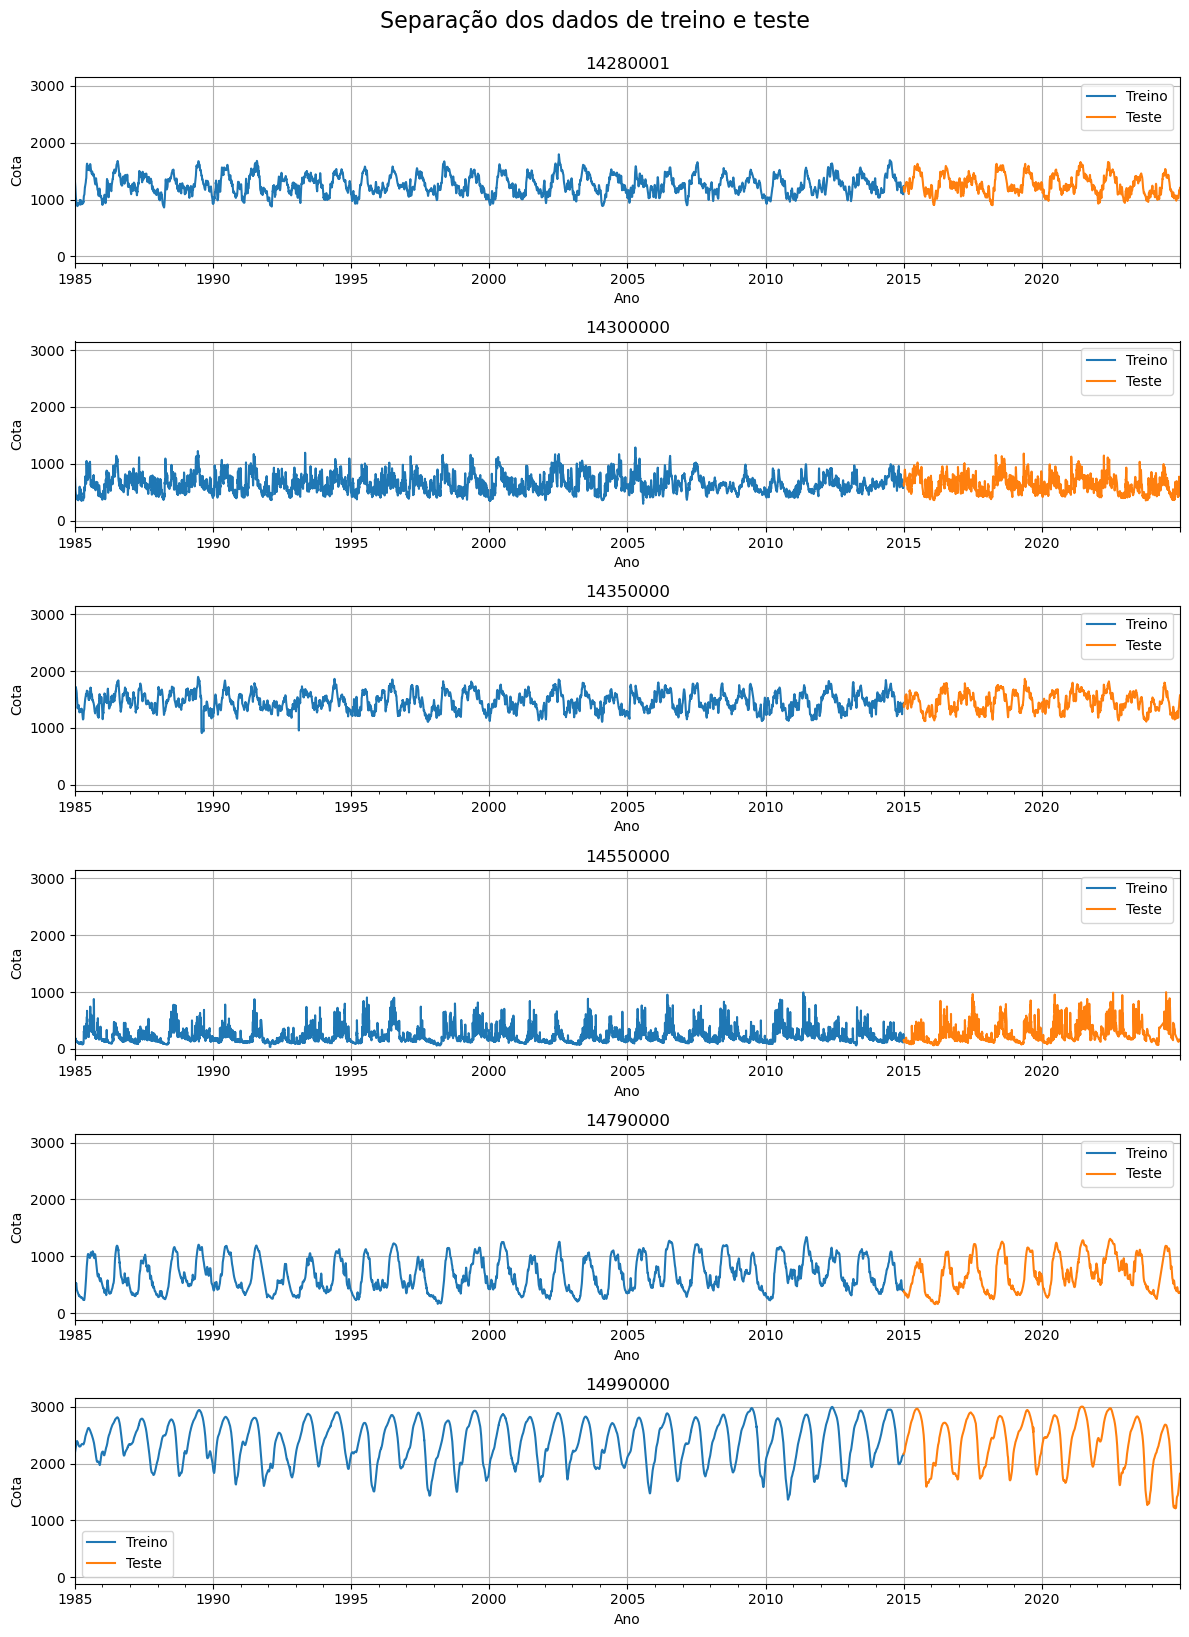

In [5]:
treino = dados[:'2014-12-31']
teste = dados['2015-01-01':]

fig, ax = plt.subplots(dados.shape[1], 1, figsize=(12, 16), sharey=True)
fig.subplots_adjust(hspace=1)
ax = ax.ravel()

for i, col in enumerate(dados):
    treino[col].plot(ax=ax[i], label='Treino')
    teste[col].plot(ax=ax[i], label='Teste')
    ax[i].set_title(col)
    ax[i].set_ylabel('Cota')
    ax[i].set_xlabel('Ano')
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.suptitle('Separação dos dados de treino e teste', fontsize=16, y=1.02)
plt.show()

### Aprendizado de Máquina

##### Funções

In [6]:
def train_test_model(model, name_model, series, name_column, split, janela, steps):
    # Criação de janelas
    X, y = ml_func.create_multi_step_dataset(series.values, janela, steps)

    # Separação dos cojuntos
    x_train = X[:split-janela]
    y_train = y[:split-janela]

    x_test = X[split-janela:]
    y_test = y[split-janela:]

    # Normalização dos dados
    x_scale = MinMaxScaler()
    y_scale = MinMaxScaler()

    x_train = x_scale.fit_transform(x_train)
    x_test = x_scale.transform(x_test)

    y_train = y_scale.fit_transform(y_train)

    # Treino
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    model.fit(x_train, y_train, epochs=100, verbose=0, callbacks=early_stop)

    # Predição
    pred = model.predict(x_test, verbose=0)
    pred_inv = y_scale.inverse_transform(pred)

    # Métrica R²
    print(f"\nR² total: {r2_score(y_test, pred_inv):.4f}")
    print(f"R² para o dia {steps}: {r2_score(y_test[:, steps-1], pred_inv[:, steps-1]):.4f}")

    # Plot dos dados Observados e Preditos
    max_year, min_year = eda._max_min_year_(series)

    plt.figure(figsize=(16, 4))
    plt.plot(y_test[:, steps-1], linestyle='-', label='Observado')
    plt.plot(pred_inv[:, steps-1], linestyle='-', label='Predito')

    plt.axhline(y=np.mean(series.loc[max_year]), linestyle='--', color='red', label='Média Máxima')
    plt.axhline(y=np.mean(series.loc[min_year]), linestyle='--', color='green', label='Média Mínima')

    plt.legend()
    plt.title(f'{name_model} - Estação {name_column} - Dia {steps}')
    plt.xlabel('Tempo (dias)')
    plt.ylabel('Cota (cm)')
    plt.tight_layout()
    plt.grid(True)
    plt.show()


In [7]:
janela = 15
steps = 15

##### MLP

I0000 00:00:1755530247.842927 2502228 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10151 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-08-18 11:17:28.878412: I external/local_xla/xla/service/service.cc:163] XLA service 0x71dca00073a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-18 11:17:28.878427: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2025-08-18 11:17:28.893194: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-18 11:17:28.975950: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
I0000 00:00:1755530249.663304 2502787 device_compiler.h:196] Compiled cluster using XLA!  This line is logged


R² total: 0.8423
R² para o dia 15: 0.6780


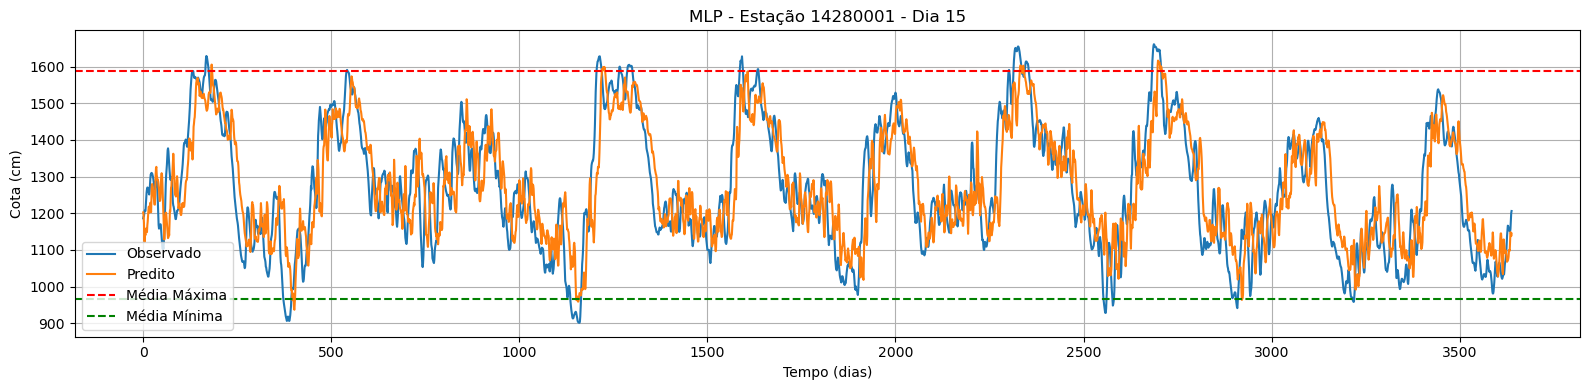


R² total: 0.4703
R² para o dia 15: 0.2575


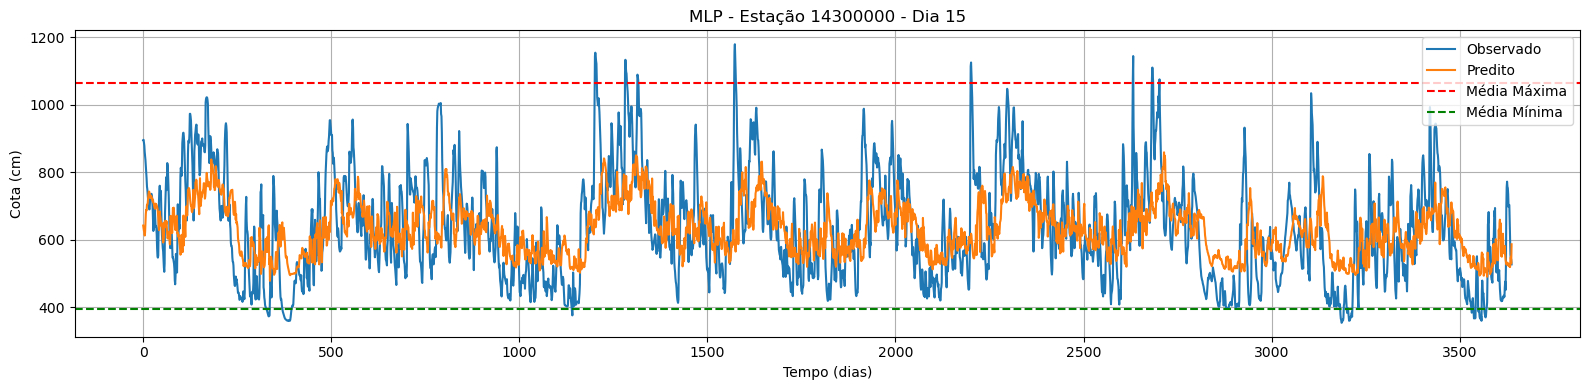


R² total: 0.7847
R² para o dia 15: 0.5558


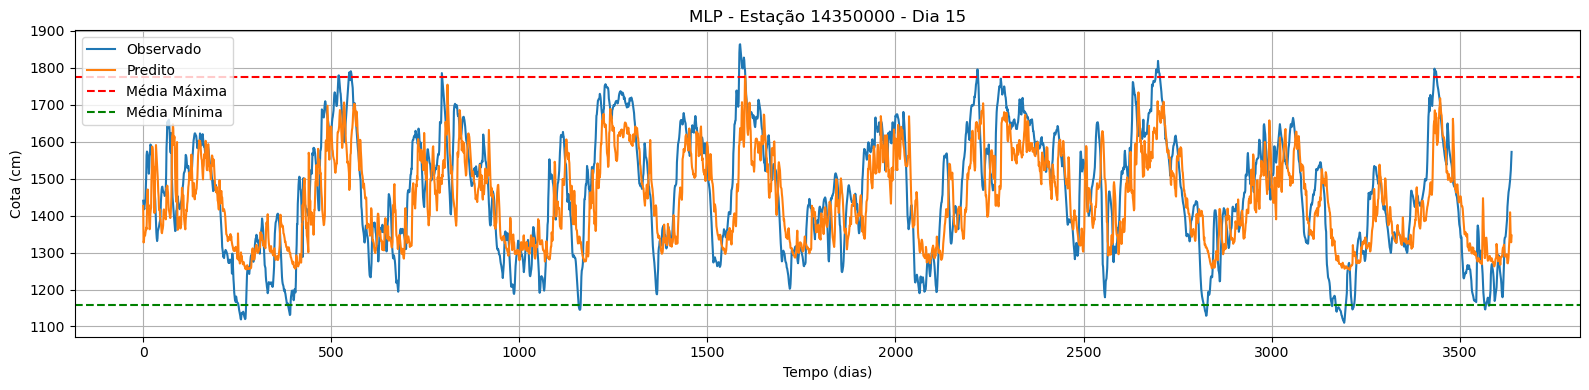


R² total: 0.4606
R² para o dia 15: 0.3048


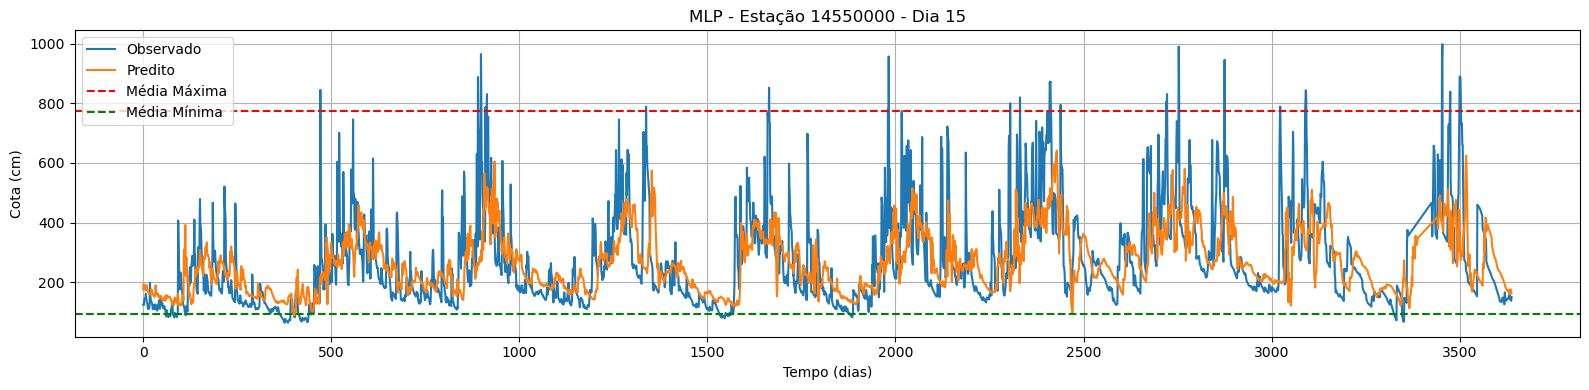


R² total: 0.9540
R² para o dia 15: 0.8920


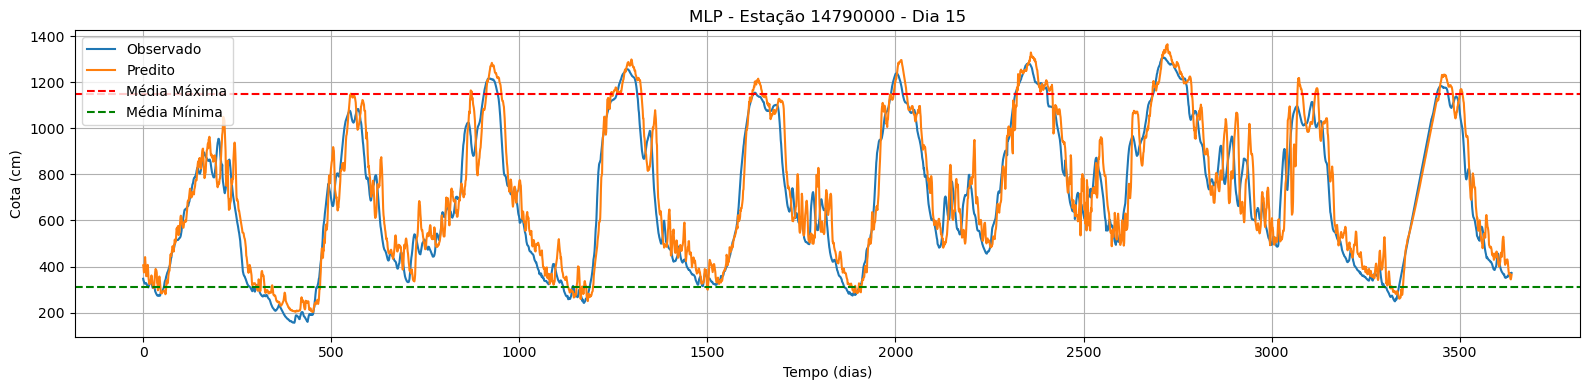


R² total: 0.9950
R² para o dia 15: 0.9879


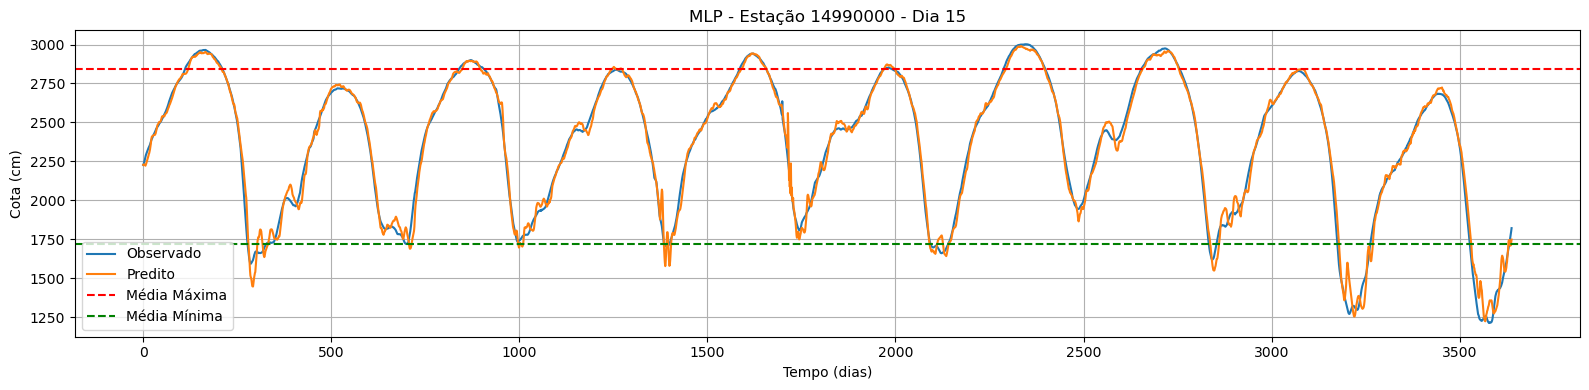

In [8]:
for c in dados.columns:
    mlp = ann.build_model_mlp((30, 30), janela, steps)
    train_test_model(mlp, 'MLP', dados[c], c, treino.shape[0], janela, steps)

##### LSTM


R² total: 0.8436
R² para o dia 15: 0.6819


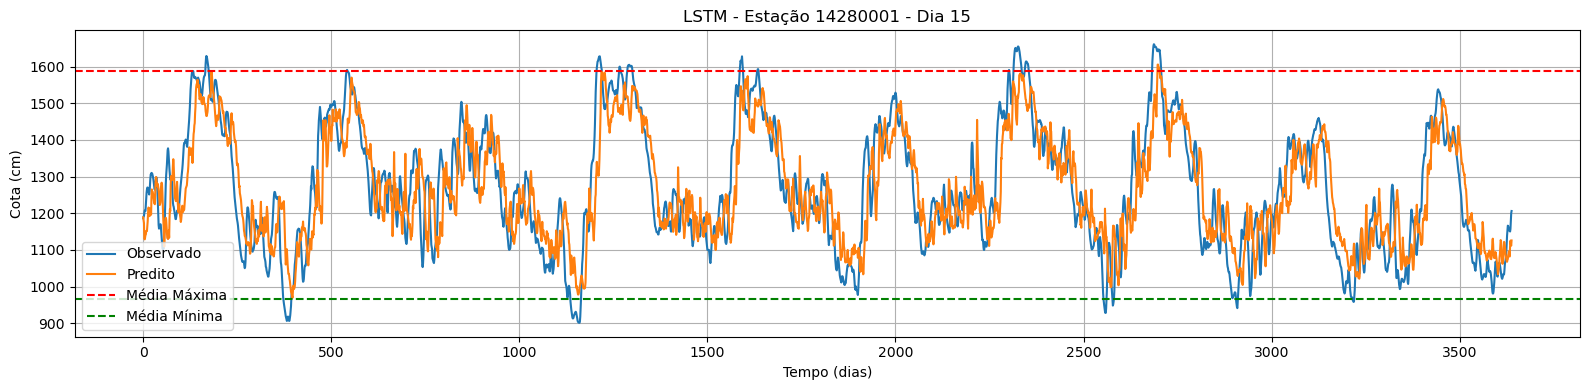


R² total: 0.4341
R² para o dia 15: 0.2139


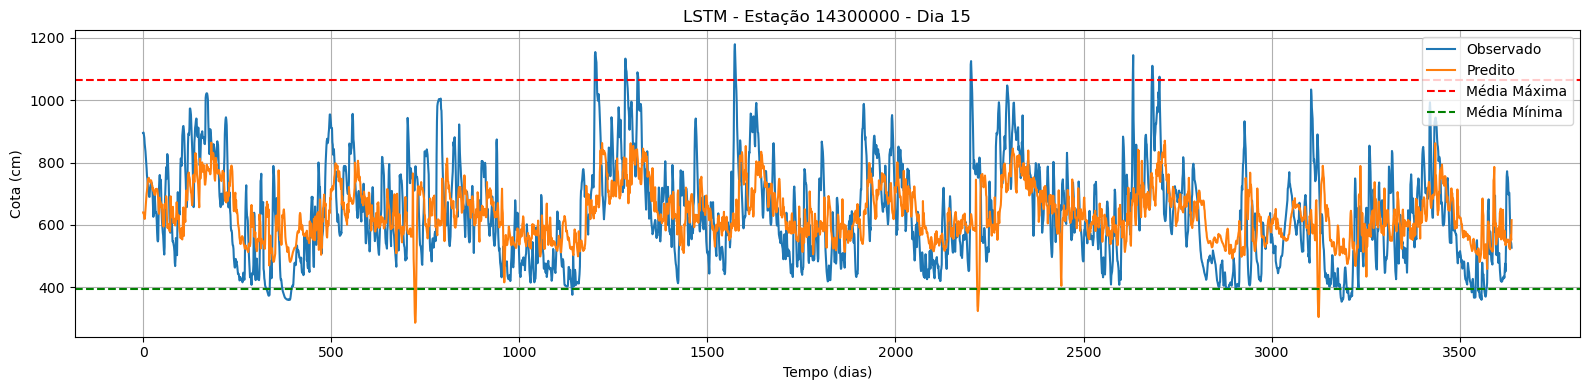


R² total: 0.7888
R² para o dia 15: 0.5570


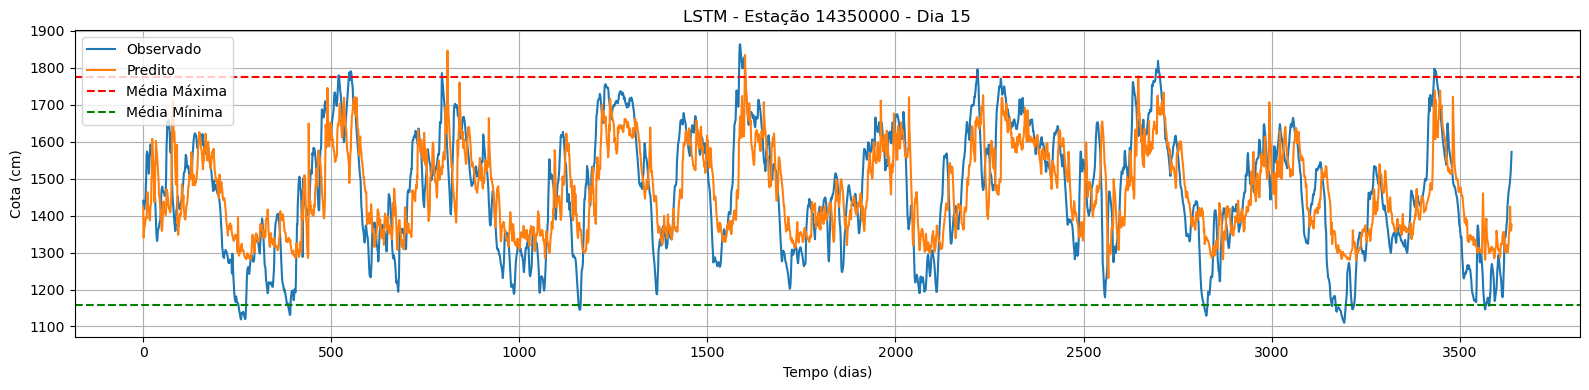


R² total: 0.4570
R² para o dia 15: 0.2942


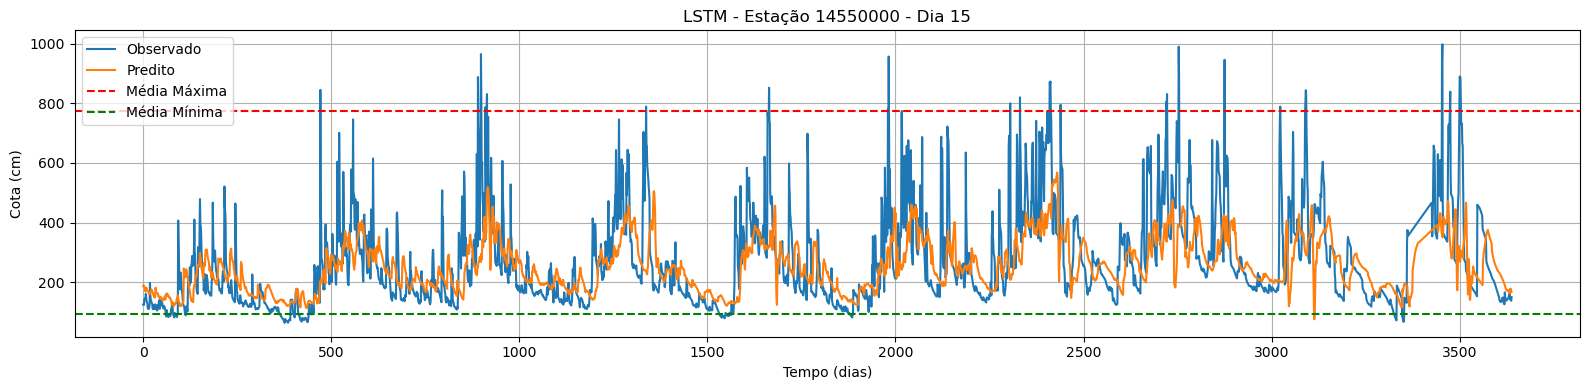


R² total: 0.9614
R² para o dia 15: 0.9026


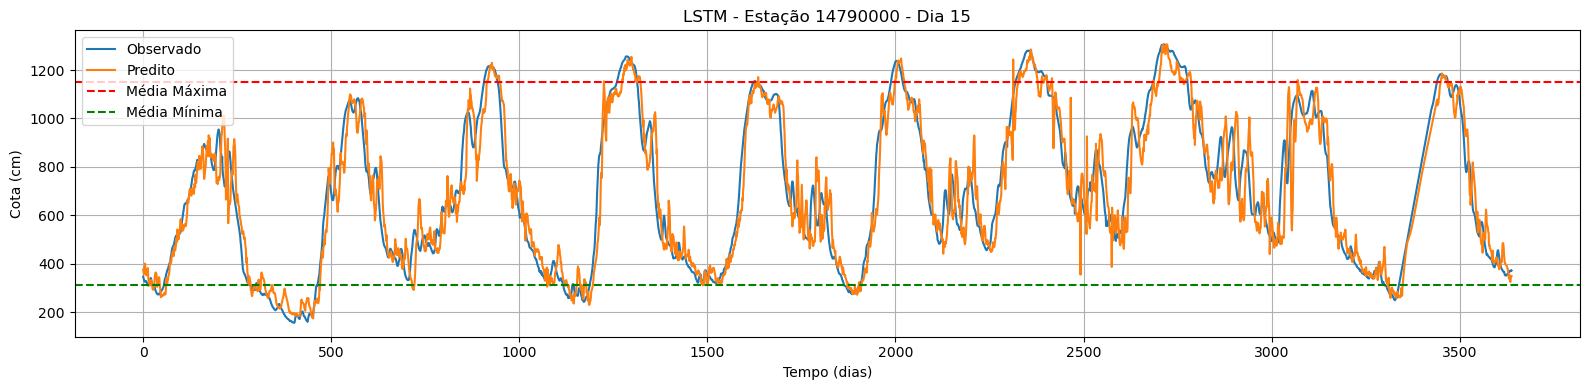


R² total: 0.9958
R² para o dia 15: 0.9874


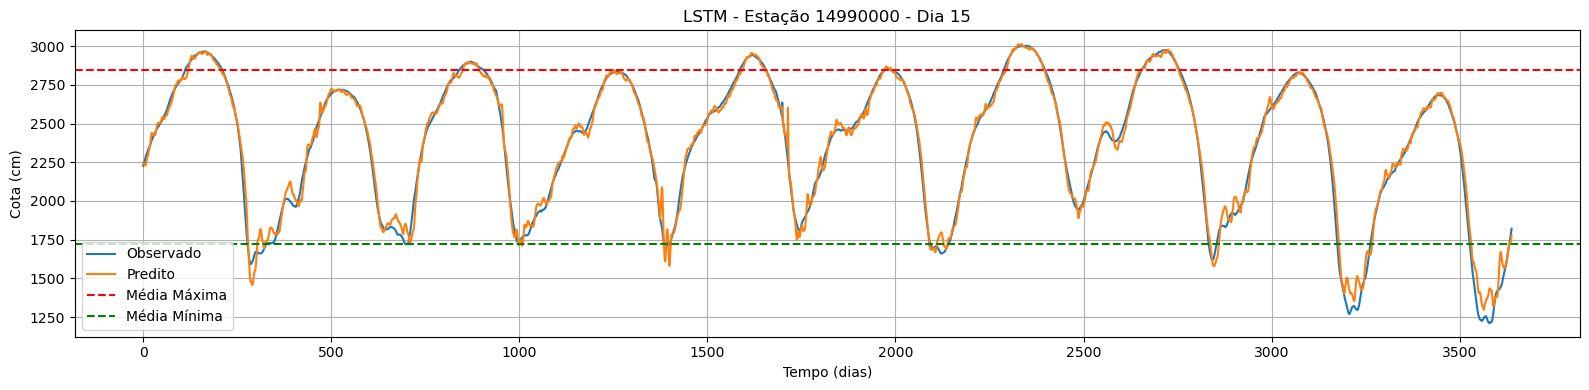

In [9]:
for c in dados.columns:
    lstm = ann.build_model_lstm(30, janela, steps)
    train_test_model(lstm, 'LSTM', dados[c], c, treino.shape[0], janela, steps)